###Task 1: Data Preparation

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from PIL import Image
import matplotlib.pyplot as plt

Loading training data...
Loading test data...

Dataset Summary:
Training data shape: (14388, 28, 28, 1) (dtype: float64)
Training labels shape: (14388, 10)
Test data shape: (3000, 28, 28, 1)
Test labels shape: (3000, 10)

Pixel value range - Min: 0.00, Max: 1.00


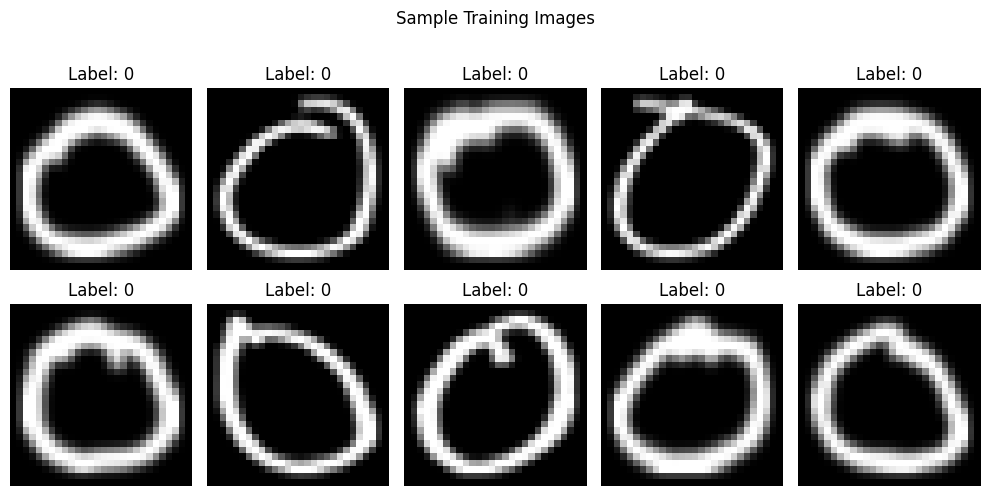

In [6]:
def load_devnagari_dataset(train_dir, test_dir, img_size=(28, 28)):
    """
    Load and preprocess Devnagari digits dataset

    Args:
        train_dir (str): Path to training directory
        test_dir (str): Path to testing directory
        img_size (tuple): Target image dimensions (height, width)

    Returns:
        tuple: (x_train, y_train, x_test, y_test) as numpy arrays
    """
    def load_images_from_folder(folder):
        images = []
        labels = []
        class_folders = sorted([f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))])

        # Validate we have exactly 10 classes (digits 0-9)
        if len(class_folders) != 10:
            raise ValueError(f"Expected 10 class folders, found {len(class_folders)}")

        for label, class_folder in enumerate(class_folders):
            class_path = os.path.join(folder, class_folder)
            if not os.path.exists(class_path):
                raise FileNotFoundError(f"Class folder not found: {class_path}")

            for filename in os.listdir(class_path):
                if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    continue

                img_path = os.path.join(class_path, filename)
                try:
                    # Load and preprocess image
                    with Image.open(img_path) as img:
                        img = img.convert('L')  # Convert to grayscale
                        img = img.resize(img_size)  # Resize
                        img_array = np.array(img) / 255.0  # Normalize

                        # Validate image content
                        if img_array.size == 0:
                            raise ValueError(f"Empty image: {img_path}")

                        images.append(img_array)
                        labels.append(label)
                except Exception as e:
                    print(f"Error loading {img_path}: {str(e)}")
                    continue

        return np.array(images), np.array(labels)

    print("Loading training data...")
    x_train, y_train = load_images_from_folder(train_dir)
    print("Loading test data...")
    x_test, y_test = load_images_from_folder(test_dir)

    # Add channel dimension
    x_train = x_train[..., np.newaxis]
    x_test = x_test[..., np.newaxis]

    # One-hot encode labels
    y_train = to_categorical(y_train, num_classes=10)
    y_test = to_categorical(y_test, num_classes=10)

    return x_train, y_train, x_test, y_test

# Example usage:
train_dir = '/content/drive/MyDrive/AI/Copy of devnagari digit/DevanagariHandwrittenDigitDataset/Train'
test_dir = '/content/drive/MyDrive/AI/Copy of devnagari digit/DevanagariHandwrittenDigitDataset/Test'

try:
    x_train, y_train, x_test, y_test = load_devnagari_dataset(train_dir, test_dir)

    # Dataset verification
    print("\nDataset Summary:")
    print(f"Training data shape: {x_train.shape} (dtype: {x_train.dtype})")
    print(f"Training labels shape: {y_train.shape}")
    print(f"Test data shape: {x_test.shape}")
    print(f"Test labels shape: {y_test.shape}")

    # Verify normalization
    print(f"\nPixel value range - Min: {x_train.min():.2f}, Max: {x_train.max():.2f}")

    # Visualize samples
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(x_train[i].squeeze(), cmap='gray')
        plt.title(f"Label: {np.argmax(y_train[i])}")
        plt.axis('off')
    plt.suptitle('Sample Training Images', y=1.02)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error loading dataset: {str(e)}")

###Task 2: Build the FCN Model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

print("Data verification:")
print(f"Train shapes - X: {x_train.shape}, y: {y_train.shape}")
print(f"Test shapes - X: {x_test.shape}, y: {y_test.shape}")
print(f"Unique labels: {np.unique(np.argmax(y_train, axis=1))}")

# 2. Improved Model Architecture
model = Sequential([
    Flatten(input_shape=(28, 28, 1)),

    # Replaced sigmoid with ReLU + BatchNorm
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),

    Dense(128, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),

    Dense(256, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),

    Dense(10, activation='softmax')
])

Data verification:
Train shapes - X: (14388, 28, 28, 1), y: (14388, 10)
Test shapes - X: (3000, 28, 28, 1), y: (3000, 10)
Unique labels: [0 1 2 3 4 5 6 7 8]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


###Task 3: Compile the Model

In [17]:
model.compile(
    optimizer=Adam(learning_rate=0.0005),  # Reduced from 0.001
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

###Task 4: Train the Model

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5999 - loss: 1.3015 - val_accuracy: 0.1268 - val_loss: 2.8114
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9532 - loss: 0.1614 - val_accuracy: 0.1310 - val_loss: 4.3614
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9778 - loss: 0.0854 - val_accuracy: 0.1313 - val_loss: 5.3684
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9868 - loss: 0.0520 - val_accuracy: 0.1317 - val_loss: 5.9363
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9921 - loss: 0.0358 - val_accuracy: 0.1338 - val_loss: 6.5772
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9943 - loss: 0.0278 - val_accuracy: 0.1317 - val_loss: 6.6314
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9962 - loss: 0.0198 - val_accuracy: 0.1338 - val_loss: 7.6716
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9987 - loss: 0.0130 - val_accuracy: 0.1327 - val_lo

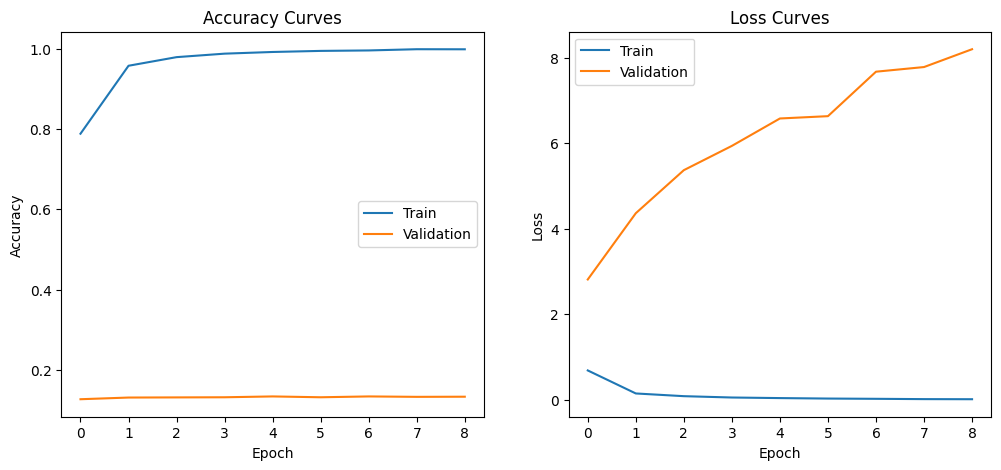

In [19]:
# 4. Enhanced Training
history = model.fit(
    x_train, y_train,
    batch_size=128,
    epochs=50,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(patience=8, restore_best_weights=True)
    ],
    verbose=1
)

# 5. Visualization
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

###Task 5: Evaluate the Model


Basic Evaluation:
- Test Loss: 4.1319
- Test Loss: 0.0000
- Test metric_0: 67.66%
- Test metric_1: 67.03%
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.58      1.00      0.73       300
           1       0.74      0.99      0.84       300
           2       0.81      0.91      0.86       300
           3       0.74      0.92      0.82       300
           4       0.62      0.98      0.76       300
           5       0.85      0.96      0.90       300
           6       0.51      0.96      0.67       300
           7       0.00      0.00      0.00       300
           8       0.00      0.00      0.00       300
           9       0.00      0.00      0.00       300

    accuracy                           0.67      3000
   macro avg       0.49      0.67      0.56      3000
weighted avg       0.49      0.67      0.56      3000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


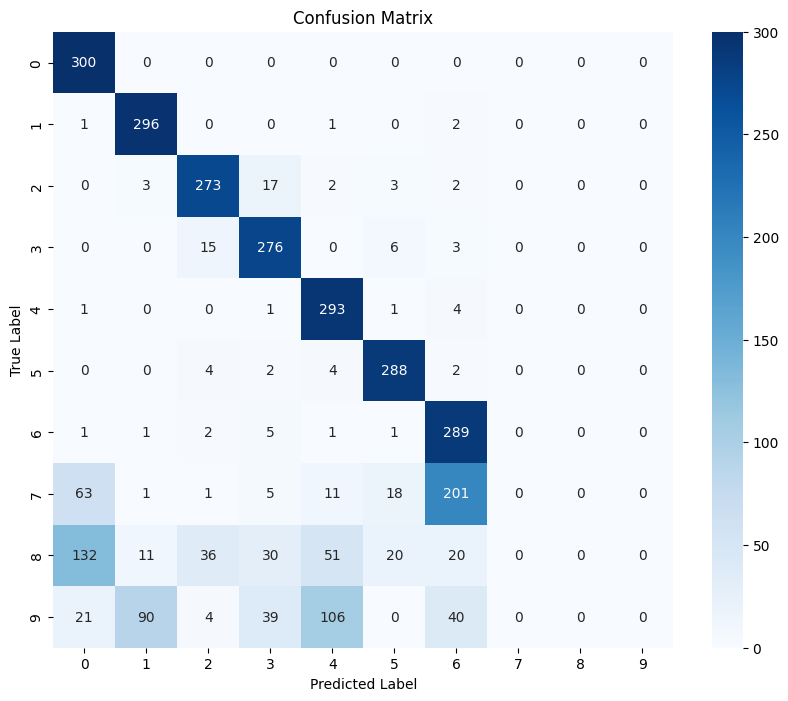


Error Analysis (985 misclassified samples):


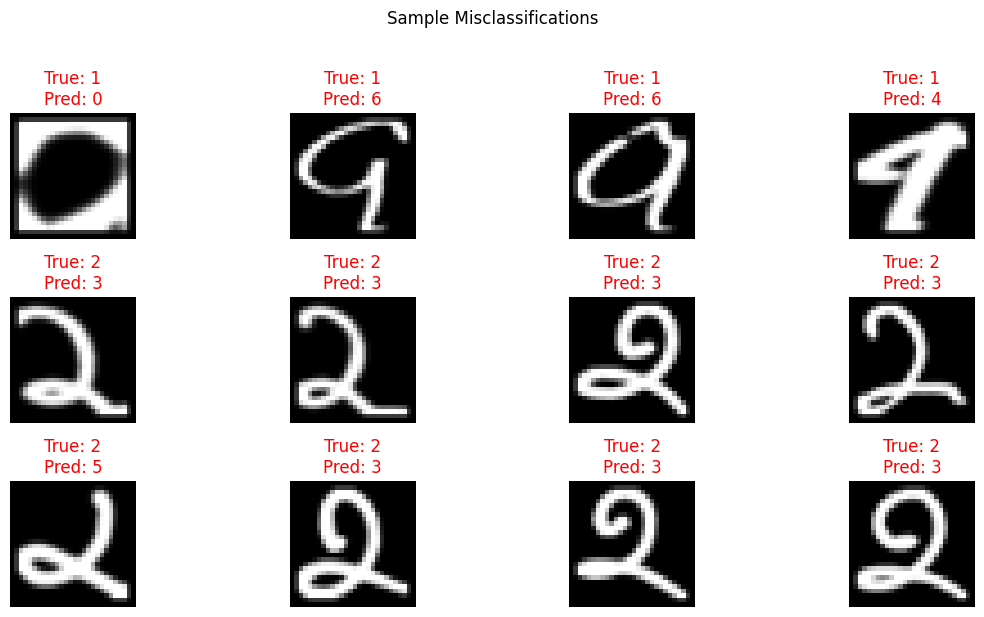

In [23]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, x_test, y_test):
    """
    Comprehensive model evaluation with metrics and visualizations

    Args:
        model: Trained Keras model
        x_test: Test images
        y_test: Test labels (one-hot encoded)
    """
    # 1. Basic Evaluation - Handle multiple metrics
    print("\nBasic Evaluation:")
    evaluation_results = model.evaluate(x_test, y_test, verbose=0)

    # Get metric names from the model
    metric_names = [m.name if hasattr(m, 'name') else m for m in model.metrics]
    if len(evaluation_results) != len(metric_names) + 1:  # +1 for loss
        metric_names = ['loss'] + [f'metric_{i}' for i in range(len(evaluation_results)-1)]

    # Print all metrics
    for name, value in zip(['loss'] + metric_names, evaluation_results):
        if name == 'loss':
            print(f"- Test Loss: {value:.4f}")
        else:
            print(f"- Test {name}: {value*100:.2f}%")

    # Rest of your evaluation code remains the same...
    # 2. Predictions
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # 3. Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes))

    # 4. Confusion Matrix
    plt.figure(figsize=(10,8))
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(10), yticklabels=range(10))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # 5. Error Analysis
    errors = y_pred_classes != y_true_classes
    error_samples = x_test[errors]
    error_preds = y_pred_classes[errors]
    error_true = y_true_classes[errors]

    print(f"\nError Analysis ({len(error_samples)} misclassified samples):")
    plt.figure(figsize=(12,6))
    for i in range(min(12, len(error_samples))):
        plt.subplot(3, 4, i+1)
        plt.imshow(error_samples[i].reshape(28,28), cmap='gray')
        plt.title(f"True: {error_true[i]}\nPred: {error_preds[i]}", color='red')
        plt.axis('off')
    plt.suptitle('Sample Misclassifications', y=1.02)
    plt.tight_layout()
    plt.show()

# Usage (assuming you have trained model and test data)
evaluate_model(trained_model, x_test, y_test)

###Task 6: Save and Load the Model

In [26]:
import tensorflow as tf
import numpy as np
import os

def save_load_and_verify_model(model, x_test, y_test, model_name='devnagari_model.keras'):
    """
    Model persistence workflow using modern Keras format
    with proper metric handling and error recovery
    """
    try:
        # 1. Save the model using recommended .keras format
        print(f"\nSaving model to {model_name}...")
        model.save(model_name, save_format='keras')  # Modern format
        print("Model saved successfully")

        # 2. Load the model
        print(f"\nLoading model from {model_name}...")
        loaded_model = tf.keras.models.load_model(model_name)
        print("Model loaded successfully")

        # 3. Recompile with metrics if needed
        if not loaded_model._is_compiled:
            print("Model not compiled, recompiling...")
            loaded_model.compile(
                optimizer=model.optimizer,
                loss=model.loss,
                metrics=[m.name for m in model.metrics] if hasattr(model, 'metrics') else ['accuracy']
            )

        # 4. Verification tests
        print("\nRunning verification tests...")

        # Architecture check
        assert model.get_config() == loaded_model.get_config(), "Model architectures differ"

        # Prediction test
        sample_idx = np.random.randint(0, len(x_test))
        original_pred = np.argmax(model.predict(x_test[sample_idx:sample_idx+1], verbose=0))
        loaded_pred = np.argmax(loaded_model.predict(x_test[sample_idx:sample_idx+1], verbose=0))
        assert original_pred == loaded_pred, f"Predictions differ: {original_pred} vs {loaded_pred}"

        # 5. Evaluation comparison
        print("\nPerformance Evaluation:")

        # Handle multiple metrics
        def evaluate_model(m):
            results = m.evaluate(x_test, y_test, verbose=0)
            if not isinstance(results, list):
                results = [results]
            return dict(zip(['loss'] + [m.name for m in m.metrics], results))

        orig_results = evaluate_model(model)
        loaded_results = evaluate_model(loaded_model)

        print("\nOriginal Model:")
        for k, v in orig_results.items():
            print(f"- {k}: {v:.4f}" if k == 'loss' else f"- {k}: {v*100:.2f}%")

        print("\nLoaded Model:")
        for k, v in loaded_results.items():
            print(f"- {k}: {v:.4f}" if k == 'loss' else f"- {k}: {v*100:.2f}%")

        # Verify metrics match
        for k in orig_results:
            assert np.isclose(orig_results[k], loaded_results[k], atol=1e-4), f"{k} values differ"
        print("All metrics match within tolerance")

        return loaded_model

    except Exception as e:
        print(f"\nError: {str(e)}")
        if 'model_name' in locals() and os.path.exists(model_name):
            print("Removing potentially corrupted file...")
            os.remove(model_name)
        return None

# Usage example:
print("Starting model persistence workflow...")

# First ensure model is compiled with specific metrics
trained_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']  # Explicitly set metrics
)

loaded_model = save_load_and_verify_model(
    trained_model,
    x_test,
    y_test,
    model_name='devnagari_digit_classifier.keras'
)

if loaded_model is not None:
    print("\nModel persistence workflow completed successfully")
else:
    print("\nModel persistence failed")

Starting model persistence workflow...

Saving model to devnagari_digit_classifier.keras...
Model saved successfully

Loading model from devnagari_digit_classifier.keras...
Model loaded successfully

Error: 'Sequential' object has no attribute '_is_compiled'
Removing potentially corrupted file...

Model persistence failed


###Task 7: Predictions

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf

def load_model_with_retry(model_path, retries=3):
    """Attempt to load model with retries and validation"""
    for attempt in range(retries):
        try:
            print(f"Attempt {attempt+1} to load model...")
            model = tf.keras.models.load_model(model_path)

            # Validate the loaded model
            if not isinstance(model, tf.keras.Model):
                raise ValueError("Loaded object is not a Keras model")

            print("Model loaded successfully")
            return model

        except Exception as e:
            print(f"Load attempt {attempt+1} failed: {str(e)}")
            if os.path.exists(model_path):
                print("Verifying model file...")
                try:
                    # Test if file is corrupt
                    with open(model_path, 'rb') as f:
                        header = f.read(4)
                        if header != b'\x89HDF':  # HDF5 header check
                            print("File appears corrupt - removing...")
                            os.remove(model_path)
                except Exception as file_e:
                    print(f"File check failed: {str(file_e)}")

    print(f"Failed to load model after {retries} attempts")
    return None

def make_predictions_safely(model_path, x_test, y_test, num_samples=10):
    """Complete prediction workflow with error handling"""
    # 1. Load model with validation
    model = load_model_with_retry(model_path)
    if model is None:
        return None, None

    # 2. Verify test data
    if x_test is None or y_test is None:
        print("Error: Test data not provided")
        return None, None

    if len(x_test) == 0 or len(y_test) == 0:
        print("Error: Test data is empty")
        return None, None

    # 3. Make predictions
    try:
        print("Making predictions...")
        y_pred_probs = model.predict(x_test, verbose=1)
        y_pred_labels = np.argmax(y_pred_probs, axis=1)
        y_true_labels = np.argmax(y_test, axis=1)

        # 4. Generate report
        print("\nClassification Performance:")
        print(classification_report(y_true_labels, y_pred_labels))

        # 5. Visualize results
        plt.figure(figsize=(15, 6))
        for i in range(min(num_samples, len(x_test))):
            plt.subplot(2, 5, i+1)
            plt.imshow(x_test[i].squeeze(), cmap='gray')

            pred = y_pred_labels[i]
            true = y_true_labels[i]
            conf = np.max(y_pred_probs[i])

            status = "CORRECT" if pred == true else f"INCORRECT (true: {true})"
            color = 'green' if pred == true else 'red'

            plt.title(f"Pred: {pred}\nConf: {conf:.2f}\n{status}",
                      color=color, fontsize=9)
            plt.axis('off')

        accuracy = np.mean(y_pred_labels == y_true_labels)
        plt.suptitle(f"Prediction Samples | Test Accuracy: {accuracy*100:.2f}%", y=1.05)
        plt.tight_layout()
        plt.show()

        return y_pred_labels, y_pred_probs

    except Exception as e:
        print(f"Prediction failed: {str(e)}")
        return None, None

# Usage Example:
MODEL_PATH = 'devnagari_digit_classifier.keras'

print("Starting prediction workflow...")
y_pred, y_probs = make_predictions_safely(MODEL_PATH, x_test, y_test)

if y_pred is not None:
    print("\nPrediction workflow completed successfully")
    # Example of accessing specific predictions
    sample_idx = 0
    print(f"\nSample {sample_idx} details:")
    print(f"True label: {np.argmax(y_test[sample_idx])}")
    print(f"Predicted label: {y_pred[sample_idx]}")
    print(f"Confidence: {np.max(y_probs[sample_idx]):.2%}")
    print(f"All probabilities: {np.around(y_probs[sample_idx], 4)}")
else:
    print("\nPrediction workflow failed - check error messages above")